In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git >ou

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-oxkpcvsm
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-oxkpcvsm
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=5fbf9243342ffb2b508741819e7fd770dd04618c91d9c88d2fe53577d1776df9
  Stored in directory: /tmp/pip-ephem-wheel-cache-b46l5hoz/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [27]:
from segment_anything import SamPredictor, sam_model_registry
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import base64
import requests
import torch
path_mode='/content/sam_vit_b_01ec64.pth'
if not os.path.exists(path_mode):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
sam = sam_model_registry["vit_b"](checkpoint=path_mode)
predictor = SamPredictor(sam)

def remove_background(img_base64_encoding,x,y):
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  predictor.model.to(device)
  img_bytes=base64.b64decode(img_base64_encoding)
  img=cv2.imdecode(np.frombuffer(img_bytes,dtype=np.uint8),cv2.IMREAD_COLOR)
  predictor.set_image(img)
  masks, _, _ = predictor.predict(
          point_coords = np.asarray([[x, y]]),
          point_labels = np.asarray([1]),
          multimask_output = True)
  C,H,W=masks.shape
  result_masks=np.zeros((H,W),dtype=bool)
  for j in range(C):
    result_masks|=masks[j,:,:]
  result_masks=result_masks.astype(np.uint8)

  alpha_channel=np.ones(result_masks.shape,dtype=result_masks.dtype)*255
  alpha_channel[result_masks==0]=0
  result_img=cv2.merge((img,alpha_channel))
  _,result_img_bytes=cv2.imencode('.png',result_img)

  result_img_bytes=result_img_bytes.tobytes()
  result_img_bytes_encoded_base64=base64.b64encode(result_img_bytes).decode('utf-8')
  return result_img_bytes_encoded_base64

# Modelbit


In [ ]:
!pip install modelbit

In [17]:
import modelbit
mb = modelbit.login()

In [28]:
mb.deploy(remove_background)

Uploading 'predictor': 100%|██████████| 348M/348M [00:10<00:00, 32.0MB/s]


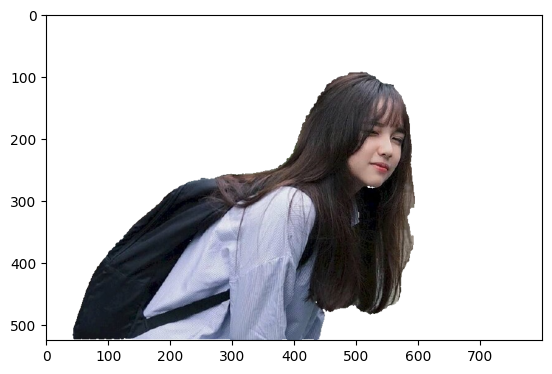

In [40]:
path_img='/content/anh-gai-xinh-toc-dai-cute-de-thuong-4-07-13-44-39.jpg'
if not os.path.exists(path_img):
  !wget https://inkythuatso.com/uploads/thumbnails/800/2022/05/anh-gai-xinh-toc-dai-cute-de-thuong-4-07-13-44-39.jpg

x,y=400,500
img=cv2.imread(path_img)
_,img_bytes=cv2.imencode('.png',img)
img_bytes=img_bytes.tobytes()
img_bytes_encoded_base64=base64.b64encode(img_bytes).decode('utf-8')

api_url="https://quanghoang.ap-south-1.modelbit.com/v1/remove_background/latest"
api_data={'data':[img_bytes_encoded_base64,x,y]}
response= requests.post(api_url,json=api_data)
if 'data' not in response.json().keys():
  print(response.json()['error'])
else:
  result_img_base64_encoding=response.json()['data']
  result_img_bytes=base64.b64decode(result_img_base64_encoding)
  result_img=cv2.imdecode(np.frombuffer(result_img_bytes,dtype=np.uint8),cv2.IMREAD_UNCHANGED)
  plt.imshow(cv2.cvtColor(result_img,cv2.COLOR_BGRA2RGBA))
  plt.show()